In [148]:
import numpy as np
import torch

In [149]:
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import torchvision.transforms.functional as F

dtype = torch.float32

In [150]:
batch_size = 64

mnist_train = datasets.MNIST('.', download = True, train = True, transform = T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(50000)))

mnist_val = datasets.MNIST('.', download = True, train = True, transform = T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(50000, 60000)))

torch.Size([64, 1, 28, 28])


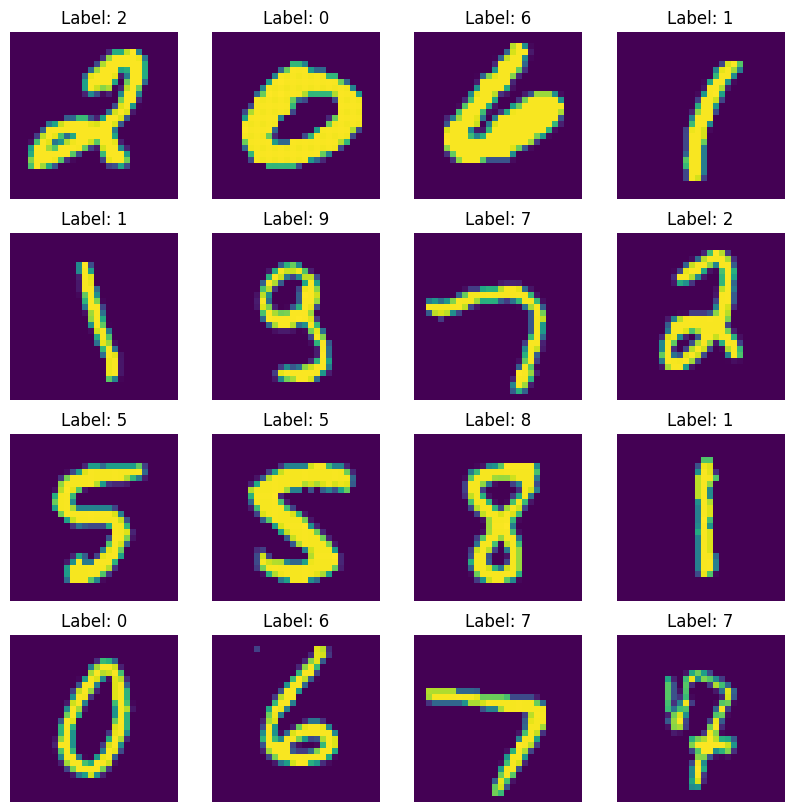

In [151]:
images, labels = next(iter(loader_train))

# Print the shape of the images and labels
print(images.shape)

# Plot the images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].permute(1, 2, 0))
    ax.axis('off')
    ax.set_title(f"Label: {labels[i]}")

plt.show()


In [178]:
def two_layer_fc(x, params):
    x = x.view(-1, 28 * 28)
    w1, w2 = params

    x = torch.relu(x @ w1)
    x = x @ w2
    
    return x

# Example usage:
dtype = torch.float
batch_size = 64  # Assuming a batch size is defined somewhere.

x = torch.zeros((batch_size, 28 * 28), dtype=dtype)
hidden_layer_size = 42

w1 = torch.zeros((28 * 28, hidden_layer_size), dtype=dtype, requires_grad=True)
w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype, requires_grad=True)

scores = two_layer_fc(x, [w1, w2])


In [179]:
def random_weight(shape):
    if len(shape) == 2:
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:])
    
    w = torch.randn(shape, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    
    return w

def zero_weight(shape):
    return torch.zeros(shape, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU.
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

tensor([[-1.2295,  1.6998,  0.9333,  1.3020, -0.4588],
        [ 1.1976,  0.3035,  0.8840,  0.6089,  0.3339],
        [ 0.2706,  0.1976,  0.0378, -0.7235, -0.7981]], requires_grad=True)

In [268]:
def check_accuracy(loader, model_fn, params):
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
        
        return acc

In [269]:
def train(model_fn, params, learning_rate, print_every=100):
    w1, w2, m1, m2 = params
    
    last_accuracy = 0   
    
    for t, (x, y) in enumerate(loader_train):
        
        with torch.no_grad():
            w1 *= m1
            w2 *= m2
            
        scores = model_fn(x, [w1, w2])
        loss = torch.nn.functional.cross_entropy(scores, y)
        loss.backward()
        
        with torch.no_grad():
            
            w1 -= learning_rate * w1.grad
            w2 -= learning_rate * w2.grad

            w1.grad.zero_()
            w2.grad.zero_()

        if t % print_every == 0:            
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            
            with torch.no_grad():
                w1 *= m1
                w2 *= m2
            
            last_accuracy = check_accuracy(loader_val, model_fn, [w1, w2])
            print()
            
    return last_accuracy

In [293]:
hidden_layer_size = 500
learning_rate = 1e-2

w1 = random_weight((28 * 28, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

initial_w1 = w1.clone().detach().requires_grad_(False)
initial_w2 = w2.clone().detach().requires_grad_(False)

m1 = torch.ones((28 * 28, hidden_layer_size), dtype=dtype)
m2 = torch.ones((hidden_layer_size, 10), dtype=dtype)

graph_info = []

graph_info.append((100, train(two_layer_fc, [w1, w2, m1, m2], learning_rate, print_every=500)))
w1 = initial_w1.clone().detach().requires_grad_(True)
w2 = initial_w2.clone().detach().requires_grad_(True)
print("Initial training done")
    
for k in range(30):
    acc = train(two_layer_fc, [w1, w2, m1, m2], learning_rate, print_every=500)
    
    all = []

    for i in range(w1.shape[0]):
        for j in range(w1.shape[1]):
            if m1[i][j] == 1:
                all.append(abs(w1[i][j].item()))
            
    for i in range(w2.shape[0]):
        for j in range(w2.shape[1]):
            if m2[i][j] == 1:
                all.append(abs(w2[i][j].item()))
    
    all = list(sorted(all))
    thres = all[int(0.1 * len(all))]
    
    with torch.no_grad():
        for i in range(m1.shape[0]):
            for j in range(m1.shape[1]):
                if abs(w1[i][j].item()) < thres:
                    m1[i][j] = 0 

                
        for i in range(m2.shape[0]):
            for j in range(m2.shape[1]):
                if abs(w2[i][j].item()) < thres:
                    m2[i][j] = 0
                
    tot_remain = float((m1 == 1).sum() + (m2 == 1).sum())
    tot = float(m1.shape[0] * m1.shape[1] + m2.shape[0] * m2.shape[1])

    w1 = initial_w1.clone().detach().requires_grad_(True)
    w2 = initial_w2.clone().detach().requires_grad_(True)
    
    print('-' * 128)
    print(k+1, "iteration of pruning done", "Percentage of remaining weights:", tot_remain / tot * 100, "%")
    print('-' * 128)
    
    graph_info.append((tot_remain / tot * 100, acc))



Iteration 0, loss = 2.4139
Checking accuracy on the val set
Got 1566 / 10000 correct (15.66%)

Iteration 500, loss = 0.6495
Checking accuracy on the val set
Got 8768 / 10000 correct (87.68%)

Initial training done
Iteration 0, loss = 2.4571
Checking accuracy on the val set
Got 1556 / 10000 correct (15.56%)

Iteration 500, loss = 0.5317
Checking accuracy on the val set
Got 8772 / 10000 correct (87.72%)

--------------------------------------------------------------------------------------------------------------------------------
1 iteration of pruning done Percentage of remaining weights: 90.0 %
--------------------------------------------------------------------------------------------------------------------------------
Iteration 0, loss = 2.0722
Checking accuracy on the val set
Got 2889 / 10000 correct (28.89%)

Iteration 500, loss = 0.6997
Checking accuracy on the val set
Got 8773 / 10000 correct (87.73%)

----------------------------------------------------------------------------

[100, 90.0, 81.0, 72.89999999999999, 65.61007556675062, 59.04911838790932, 53.14433249370277, 47.829974811083126, 43.0471032745592, 38.74256926952141, 34.86851385390428, 31.381863979848866, 28.24382871536524, 25.419647355163725, 22.877833753148614, 20.590176322418134, 18.53123425692695, 16.678337531486147, 15.010579345088162, 13.5095717884131, 12.158690176322418, 10.942821158690176, 9.848614609571788, 8.8639798488665, 7.977581863979849, 7.179848866498741, 6.461964735516373, 5.8158690176322425, 5.234508816120907, 4.711083123425692, 4.240050377833753]
[0.8768, 0.8772, 0.8773, 0.877, 0.8816, 0.8806, 0.8804, 0.8831, 0.8807, 0.882, 0.8812, 0.8803, 0.8786, 0.8782, 0.8758, 0.8717, 0.8751, 0.8737, 0.8697, 0.8715, 0.8687, 0.8678, 0.8605, 0.8607, 0.8575, 0.8533, 0.8501, 0.8474, 0.8412, 0.8365, 0.8341]


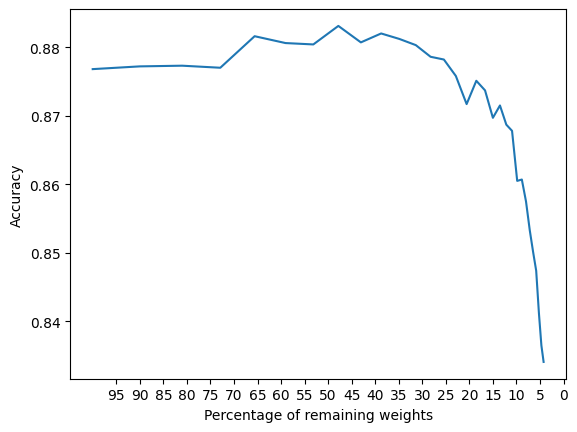

In [294]:
import matplotlib.pyplot as plt

# Extract x and y values from graph_info
x_values = [item[0] for item in graph_info]
y_values = [item[1] for item in graph_info]

print(x_values)
print(y_values)

# Plot the data
plt.plot(x_values, y_values)

# Reverse order of x-axis
plt.gca().invert_xaxis()

# find x axis labels more fine grained
plt.xticks(np.arange(0, 100, 5))

plt.xlabel('Percentage of remaining weights')
plt.ylabel('Accuracy')

# Show the plot
plt.show()
# Set x-axis scale to logarithmic with a multiplier coefficient of 0.4

